In [4]:
from nilmtk_contrib.disaggregate import Seq2Seq, Seq2Point
from nilmtk.dataset import DataSet
from nilmtk.metergroup import MeterGroup
from nilmtk.losses import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import clear_output

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.debugging.disable_traceback_filtering()
import pickle

In [5]:
class API():

    """
    The API ia designed for rapid experimentation with NILM Algorithms.
    """

    def __init__(self,params):
        """
        Initialize the API with default parameters and then start the experiment.
        """

        self.appliances = []
        self.train_submeters = []
        self.train_mains = pd.DataFrame()
        self.test_submeters = []
        self.test_mains = pd.DataFrame()
        self.gt_overall = {}
        self.pred_overall = {}
        self.classifiers=[]
        self.errors = []
        self.errors_keys = []
        self.power = params['power']
        for elems in params['appliances']:
            self.appliances.append(elems)

        self.train_datasets_dict = params['train']['datasets']
        self.test_datasets_dict = params['test']['datasets']
        self.metrics = params['test']['metrics']
        self.methods = params['methods']
        self.sample_period = params.get("sample_rate", 1)
        self.artificial_aggregate = params.get('artificial_aggregate', False)
        self.chunk_size = params.get('chunk_size', None)
        self.display_predictions = params.get('display_predictions', False)
        self.DROP_ALL_NANS = params.get("DROP_ALL_NANS", True)
        self.site_only = params.get('site_only',False)
        self.experiment()
        

    def experiment(self):
        """
        Calls the Experiments with the specified parameters
        """

        self.store_classifier_instances()
        d=self.train_datasets_dict

        for model_name, clf in self.classifiers:
            # If the model is a neural net, it has an attribute n_epochs, Ex: DAE, Seq2Point
            print ("Started training for ",clf.MODEL_NAME)

            # If the model has the filename specified for loading the pretrained model, then we don't need to load training data

            if hasattr(clf,'load_model_path'):
                if clf.load_model_path:
                    print (clf.MODEL_NAME," is loading the pretrained model")
                    continue

            # if user wants to train chunk wise
            if self.chunk_size:
                # If the classifier supports chunk wise training
                if clf.chunk_wise_training:
                    # if it has an attribute n_epochs. Ex: neural nets. Then it is trained chunk wise for every wise
                    if hasattr(clf,'n_epochs'):
                        n_epochs = clf.n_epochs
                        clf.n_epochs = 1
                    else:
                        # If it doesn't have the attribute n_epochs, this is executed. Ex: Mean, Zero
                        n_epochs = 1
                    # Training on those many chunks for those many epochs
                    print ("Chunk wise training for ",clf.MODEL_NAME)
                    for i in range(n_epochs):
                        self.train_chunk_wise(clf, d, i)

                else:
                    print ("Joint training for ",clf.MODEL_NAME)
                    self.train_jointly(clf,d)            

            # if it doesn't support chunk wise training
            else:
                print ("Joint training for ",clf.MODEL_NAME)
                self.train_jointly(clf,d)            

            print ("Finished training for ",clf.MODEL_NAME)
            clear_output()

        d=self.test_datasets_dict

        if self.chunk_size:
            print ("Chunk Wise Testing for all algorithms")
            # It means that, predictions can also be done on chunks
            self.test_chunk_wise(d)

        else:
            print ("Joint Testing for all algorithms")
            self.test_jointly(d)

    def train_chunk_wise(self, clf, d, current_epoch):
        """
        This function loads the data from buildings and datasets with the specified chunk size and trains on each of them. 
        """
            
        for dataset in d:
            # Loading the dataset
            print("Loading data for ",dataset, " dataset")          
            for building in d[dataset]['buildings']:
                # Loading the building
                train=DataSet(d[dataset]['path'])
                print("Loading building ... ",building)
                train.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                mains_iterator = train.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)
                appliance_iterators = [train.buildings[building].elec[app_name].load(chunksize = self.chunk_size, physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period) for app_name in self.appliances]
                print(train.buildings[building].elec.mains())
                for chunk_num,chunk in enumerate (train.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)):
                    # Loading the chunk for the specifeid building
                    #Dummry loop for executing on outer level. Just for looping till end of a chunk
                    print("Starting enumeration..........")
                    train_df = next(mains_iterator)
                    appliance_readings = []
                    for i in appliance_iterators:
                        try:
                            appliance_df = next(i)
                        except StopIteration:
                            appliance_df = pd.DataFrame()
                        appliance_readings.append(appliance_df)

                    if self.DROP_ALL_NANS:
                        train_df, appliance_readings = self.dropna(train_df, appliance_readings)
                    
                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            train_df+=app_reading
                    train_appliances = []

                    for cnt,i in enumerate(appliance_readings):
                        train_appliances.append((self.appliances[cnt],[i]))

                    self.train_mains = [train_df]
                    self.train_submeters = train_appliances
                    clf.partial_fit(self.train_mains, self.train_submeters, current_epoch)
                

        print("...............Finished the Training Process ...................")

    def test_chunk_wise(self,d):

        print("...............Started  the Testing Process ...................")

        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            for building in d[dataset]['buildings']:
                test=DataSet(d[dataset]['path'])
                test.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                mains_iterator = test.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)
                appliance_iterators = [test.buildings[building].elec[app_name].load(chunksize = self.chunk_size, physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period) for app_name in self.appliances]
                for chunk_num,chunk in enumerate (test.buildings[building].elec.mains().load(chunksize = self.chunk_size, physical_quantity='power', ac_type = self.power['mains'], sample_period=self.sample_period)):
                    test_df = next(mains_iterator)
                    appliance_readings = []
                    for i in appliance_iterators:
                        try:
                            appliance_df = next(i)
                        except StopIteration:
                            appliance_df = pd.DataFrame()

                        appliance_readings.append(appliance_df)

                    if self.DROP_ALL_NANS:
                        test_df, appliance_readings = self.dropna(test_df, appliance_readings)

                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        test_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            test_df+=app_reading

                    test_appliances = []

                    for cnt,i in enumerate(appliance_readings):
                        test_appliances.append((self.appliances[cnt],[i]))

                    self.test_mains = [test_df]
                    self.test_submeters = test_appliances
                    print("Results for Dataset {dataset} Building {building} Chunk {chunk_num}".format(dataset=dataset,building=building,chunk_num=chunk_num))
                    self.storing_key = str(dataset) + "_" + str(building) + "_" + str(chunk_num) 
                    self.call_predict(self.classifiers, test.metadata['timezone'])


    def train_jointly(self,clf,d):

        # This function has a few issues, which should be addressed soon
        print("............... Loading Data for training ...................")
        # store the train_main readings for all buildings
        self.train_mains = []
        self.train_submeters = [[] for i in range(len(self.appliances))]
        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            train=DataSet(d[dataset]['path'])
            for building in d[dataset]['buildings']:
                print("Loading building ... ",building)
                train.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                train_df = next(train.buildings[building].elec.mains().load(physical_quantity='power', ac_type=self.power['mains'], sample_period=self.sample_period))
                train_df = train_df[[list(train_df.columns)[0]]]
                appliance_readings = []
                
                for appliance_name in self.appliances:
                    appliance_df = next(train.buildings[building].elec[appliance_name].load(physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period))
                    appliance_df = appliance_df[[list(appliance_df.columns)[0]]]
                    appliance_readings.append(appliance_df)

                if self.DROP_ALL_NANS:
                    train_df, appliance_readings = self.dropna(train_df, appliance_readings)

                if self.artificial_aggregate:
                    print ("Creating an Artificial Aggregate")
                    train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                    for app_reading in appliance_readings:
                        train_df+=app_reading

                self.train_mains.append(train_df)
                for i,appliance_name in enumerate(self.appliances):
                    self.train_submeters[i].append(appliance_readings[i])

        appliance_readings = []
        for i,appliance_name in enumerate(self.appliances):
            appliance_readings.append((appliance_name, self.train_submeters[i]))

        self.train_submeters = appliance_readings   

        clf.partial_fit(self.train_mains,self.train_submeters)

    
    def test_jointly(self,d):
        # store the test_main readings for all buildings
        for dataset in d:
            print("Loading data for ",dataset, " dataset")
            test=DataSet(d[dataset]['path'])
            for building in d[dataset]['buildings']:
                test.set_window(start=d[dataset]['buildings'][building]['start_time'],end=d[dataset]['buildings'][building]['end_time'])
                test_mains=next(test.buildings[building].elec.mains().load(physical_quantity='power', ac_type=self.power['mains'], sample_period=self.sample_period))
                if self.DROP_ALL_NANS and self.site_only:
                    test_mains, _= self.dropna(test_mains,[])

                if self.site_only != True:
                    appliance_readings=[]

                    for appliance in self.appliances:
                        test_df=next((test.buildings[building].elec[appliance].load(physical_quantity='power', ac_type=self.power['appliance'], sample_period=self.sample_period)))
                        appliance_readings.append(test_df)
                    
                    if self.DROP_ALL_NANS:
                        test_mains , appliance_readings = self.dropna(test_mains,appliance_readings)
                
                    if self.artificial_aggregate:
                        print ("Creating an Artificial Aggregate")
                        test_mains = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
                        for app_reading in appliance_readings:
                            test_mains+=app_reading
                    for i, appliance_name in enumerate(self.appliances):
                        self.test_submeters.append((appliance_name,[appliance_readings[i]]))

                self.test_mains = [test_mains]
                self.storing_key = str(dataset) + "_" + str(building) 
                self.call_predict(self.classifiers, test.metadata["timezone"])


    def dropna(self,mains_df, appliance_dfs=[]):
        """
        Drops the missing values in the Mains reading and appliance readings and returns consistent data by copmuting the intersection
        """
        print ("Dropping missing values")

        # The below steps are for making sure that data is consistent by doing intersection across appliances
        mains_df = mains_df.dropna()
        ix = mains_df.index
        mains_df = mains_df.loc[ix]
        for i in range(len(appliance_dfs)):
            appliance_dfs[i] = appliance_dfs[i].dropna()
    
        for  app_df in appliance_dfs:
            ix = ix.intersection(app_df.index)
        mains_df = mains_df.loc[ix]
        new_appliances_list = []
        for app_df in appliance_dfs:
            new_appliances_list.append(app_df.loc[ix])
        return mains_df,new_appliances_list
    
    
    def store_classifier_instances(self):

        """
        This function is reponsible for initializing the models with the specified model parameters
        """
        for name in self.methods:
            try:
                                
                clf=self.methods[name]
                self.classifiers.append((name,clf))

            except Exception as e:
                print ("\n\nThe method {model_name} specied does not exist. \n\n".format(model_name=name))
                print (e)
    
    def call_predict(self, classifiers, timezone):

        """
        This functions computers the predictions on the self.test_mains using all the trained models and then compares different learn't models using the metrics specified
        """
        
        pred_overall={}
        gt_overall={}           
        for name,clf in classifiers:
            gt_overall,pred_overall[name]=self.predict(clf,self.test_mains,self.test_submeters, self.sample_period, timezone)

        self.gt_overall=gt_overall
        self.pred_overall=pred_overall
        if self.site_only != True:
            if gt_overall.size==0:
                print ("No samples found in ground truth")
                return None
            for metric in self.metrics:
                try:
                    loss_function = globals()[metric]                
                except:
                    print ("Loss function ",metric, " is not supported currently!")
                    continue

                computed_metric={}
                for clf_name,clf in classifiers:
                    computed_metric[clf_name] = self.compute_loss(gt_overall, pred_overall[clf_name], loss_function)
                computed_metric = pd.DataFrame(computed_metric)
                print("............ " ,metric," ..............")
                print(computed_metric) 
                self.errors.append(computed_metric)
                self.errors_keys.append(self.storing_key + "_" + metric)


        if self.display_predictions:
            if self.site_only != True:
                for i in gt_overall.columns:
                    plt.figure()
                    #plt.plot(self.test_mains[0],label='Mains reading')
                    plt.plot(gt_overall[i],label='Truth')
                    for clf in pred_overall:                
                        plt.plot(pred_overall[clf][i],label=clf)
                        plt.xticks(rotation=90)
                    plt.title(i)
                    plt.legend()
                    plt.xlabel('Time')
                    plt.ylabel('Power (W)')
                plt.show()
        
    def predict(self, clf, test_elec, test_submeters, sample_period, timezone ):
        print ("Generating predictions for :",clf.MODEL_NAME)        
        """
        Generates predictions on the test dataset using the specified classifier.
        """
        
        # "ac_type" varies according to the dataset used. 
        # Make sure to use the correct ac_type before using the default parameters in this code.   
        
           
        pred_list = clf.disaggregate_chunk(test_elec)

        # It might not have time stamps sometimes due to neural nets
        # It has the readings for all the appliances

        concat_pred_df = pd.concat(pred_list,axis=0)

        gt = {}
        for meter,data in test_submeters:
                concatenated_df_app = pd.concat(data,axis=1)
                index = concatenated_df_app.index
                gt[meter] = pd.Series(concatenated_df_app.values.flatten(),index=index)

        gt_overall = pd.DataFrame(gt, dtype='float32')
        pred = {}

        if self.site_only ==True:
            for app_name in concat_pred_df.columns:
                app_series_values = concat_pred_df[app_name].values.flatten()
                pred[app_name] = pd.Series(app_series_values)
            pred_overall = pd.DataFrame(pred,dtype='float32')
            pred_overall.plot(label="Pred")
            plt.title('Disaggregated Data')
            plt.legend()

        else:
            for app_name in concat_pred_df.columns:
                app_series_values = concat_pred_df[app_name].values.flatten()
                # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
                app_series_values = app_series_values[:len(gt_overall[app_name])]
                pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
            pred_overall = pd.DataFrame(pred,dtype='float32')
        
        return gt_overall, pred_overall


    # metrics
    def compute_loss(self,gt,clf_pred, loss_function):
        error = {}
        for app_name in gt.columns:
            error[app_name] = loss_function(gt[app_name],clf_pred[app_name])
        return pd.Series(error)      

In [21]:
experiment1 = {
    'power': {'mains': ['active'],'appliance': ['active']},
    'sample_rate': 6,
    'appliances': ['fridge', 'air conditioner', 'washing machine', 'tumble dryer', 'kettle', 'vacuum cleaner', 'electric water heating appliance', 'oven'],
    'methods': {"Seq2Seq":Seq2Seq({'sequence_length': 99}), "Seq2SPoint":Seq2Point({'sequence_length': 99})},
    'train': {
        'datasets': {
            'MIMOS': {
                'path': 'data/mimos_6_sec.h5',
                'buildings': {
                    1: {
                        'start_time': '2022-09-27',
                        'end_time': '2022-09-28'
                    },
                    2: {
                        'start_time': '2022-09-29',
                        'end_time': '2022-09-30'
                    },
                    3: {
                        'start_time': '2022-11-01',
                        'end_time': '2022-11-02'
                    },
                    4: {
                        'start_time': '2022-11-07',
                        'end_time': '2022-11-08'
                    },
                    6: {
                        'start_time': '2022-11-09',
                        'end_time': '2022-11-10'
                    },
                    7: {
                        'start_time': '2022-11-10',
                        'end_time': '2022-11-11'
                    }
                }
            }
        }
    },
    'test': {
        'datasets': {
            'MIMOS': {
                'path': 'data/mimos_6_sec.h5',
                'buildings': {
                    5: {
                        'start_time': '2022-11-08',
                        'end_time': '2022-11-09'
                    }
                }
            }
        },
        'metrics':['mae', 'rmse', 'f1score', 'nde']
    },
    'display_predictions': {
        True
    }
}

Joint Testing for all algorithms
Loading data for  MIMOS  dataset
Dropping missing values
Generating predictions for : Seq2Seq
9/9 [==============================] - 0s 32ms/step
Generating predictions for : Seq2Point
9/9 [==============================] - 1s 76ms/step
............  mae  ..............
                                     Seq2Seq  Seq2SPoint
fridge                             31.192760   33.222279
air conditioner                   175.988846  125.912376
washing machine                    19.489260   17.752977
tumble dryer                      226.211136  271.005249
kettle                            210.872711  263.325439
vacuum cleaner                    114.875252  131.604248
electric water heating appliance  288.425903  249.866806
oven                              235.338470  257.696716
............  rmse  ..............
                                     Seq2Seq  Seq2SPoint
fridge                             54.125038   53.878460
air conditioner                   

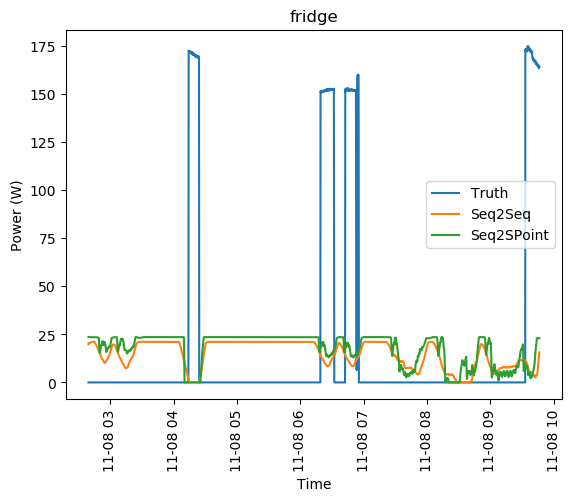

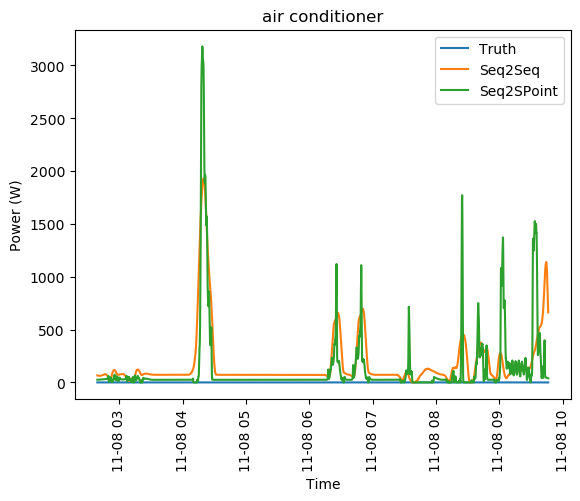

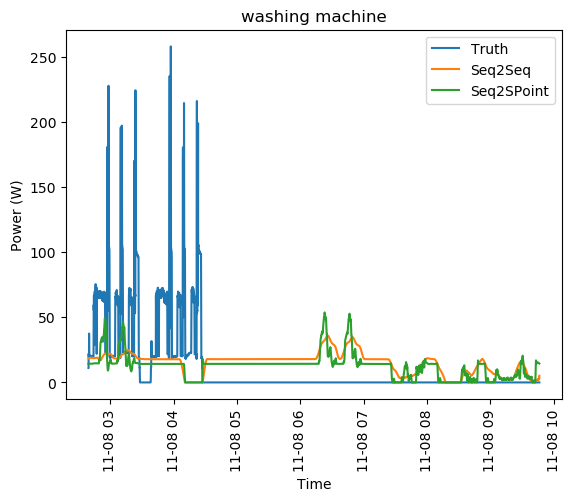

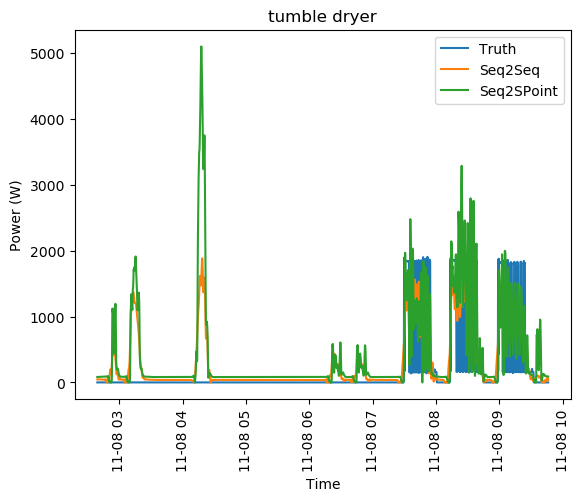

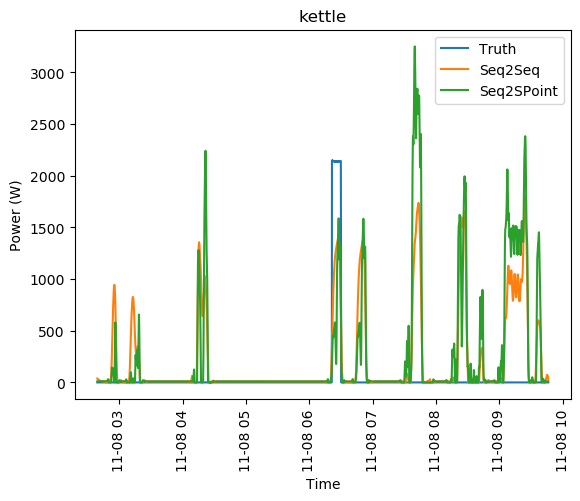

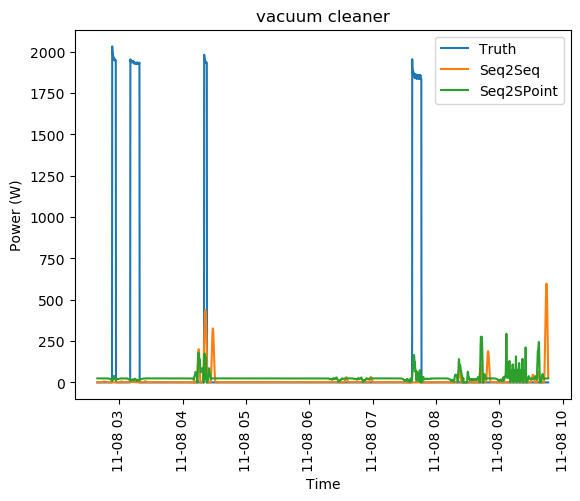

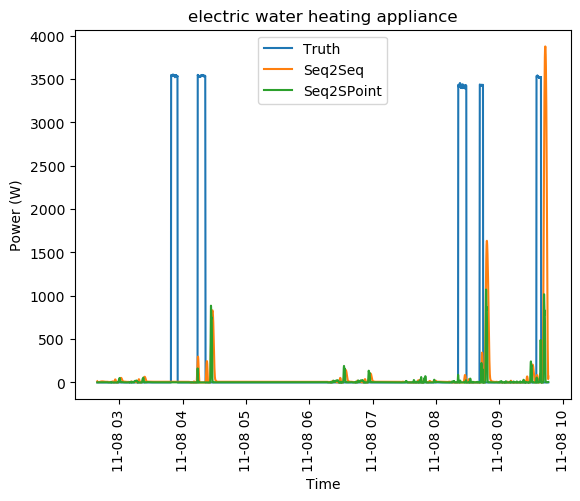

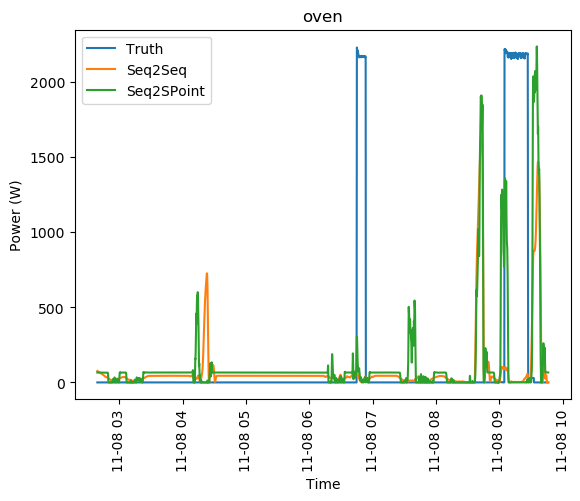

In [22]:
api_results_experiment_1 = API(experiment1)

In [12]:
def export_model(model,filename):
    example_dict = model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

In [23]:
export_model(api_results_experiment_1,'trained_models/6sec_99SL.pickle')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name

In [6]:
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [8]:
model = import_model('trained_models/30sec_99SL.pickle')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-04-22 13:48:00         4710
metadata.json                                  2024-04-22 13:48:00           64
variables.h5                                   2024-04-22 13:48:00      5409952
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
